In [1]:
%load_ext autoreload
%autoreload 2

import jax
import time
import jax.numpy as jnp
import numpy as np
import genjax
from genjax import gen, Mask, Diff
from genjax import ChoiceMapBuilder as C
from genjax import UpdateProblemBuilder as U
from genjax import SelectionBuilder as S
from genjax._src.core.interpreters.staging import Flag

import jax.tree_util as jtu
genjax.pretty()
import copy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import HTML as HTML_Display
from matplotlib.animation import FuncAnimation

from maskcombinator_model import *
from distributions import *
from config import *
from render import *

In [2]:
def and_new_keys(key, N):
    key, tmp_key = jax.random.split(key)
    new_keys = jax.random.split(tmp_key, N)
    return key, new_keys

def summary_stats(weights):
    print('mean={mean}, std={std}, min={min}, max={max}'.format(
        mean=jnp.mean(weights), std=jnp.std(weights),
        min=jnp.min(weights), max=jnp.max(weights)))

In [3]:
def make_step_choicemap(observation_chm, step_index):
    pixels = observation_chm["steps", step_index, "observations", "pixels"].value
    return C["steps", step_index, "observations", "pixels"].set(pixels)

def make_masked_combinator_step_update_problem(init_carry, observations, step, num_steps):
    argdiffs = (
        Diff.no_change(init_carry),
        Diff.unknown_change(Flag(jnp.arange(num_steps) <= step)),
    )
    chm = make_step_choicemap(observations, step)
    return U.g(argdiffs, chm)

In [4]:
def make_sequential_monte_carlo_sampler(masked_model, observations_dict, num_particles, num_steps=None):
    if not num_steps:
        num_steps = len(next(iter(observations_dict.values())))
    
    def sequential_monte_carlo_sampler(key, step_init_args):
        key, init_keys = and_new_keys(key, num_particles)
        
        init_chm = make_step_choicemap(observations_dict, 0)
        model_init_args = step_init_args, Flag(jnp.arange(num_steps) <= 0)
        init_particles, init_weights = jax.vmap(masked_model.importance, in_axes=(0, None, None))(
            init_keys, init_chm, model_init_args)

        def scan_fn(smc_scan_state, scan_input):
            (prev_weights, step_particles) = smc_scan_state
            key, time_step = scan_input
            key, resample_key = jax.random.split(key)
            # With this we recover SIS performance.
            # parents = jax.random.permutation(resample_key, jnp.arange(num_particles))
            parents = jax.random.categorical(resample_key, prev_weights, shape=(num_particles,))

            step_particles = jax.tree.map(lambda x: x[parents], step_particles)

            key, step_keys = and_new_keys(key, num_particles)
            update_problem = make_masked_combinator_step_update_problem(
                step_init_args, observations_dict, time_step, num_steps)
        
            # We can overwrite the weights since we've resampled unconditionally. If / when we 
            # modify the code to sample based on ESS, we'll have to be more careful.
            step_particles, step_weights, _, _ = jax.vmap(masked_model.update, in_axes=(0, 0, None))(
                step_keys, step_particles, update_problem)

            return (step_weights, step_particles), scan_input
            
        scan_keys = jax.random.split(key, num_steps - 1)

        (_, final_particles), _ = jax.lax.scan(
            scan_fn, (init_weights, init_particles), (scan_keys, jnp.arange(1, num_steps)))
        
        return final_particles

    return sequential_monte_carlo_sampler


In [5]:
max_fireflies = jnp.arange(1, 5)
key = jax.random.PRNGKey(101)
key, subkey = jax.random.split(key)
constraints = C.d({"n_fireflies": 1})
run_until = Flag(jnp.arange(TIME_STEPS) < TIME_STEPS)
trace, weight = jax.jit(multifirefly_model.importance)(subkey, constraints, (max_fireflies, run_until,))
gt_choices = trace.get_sample()


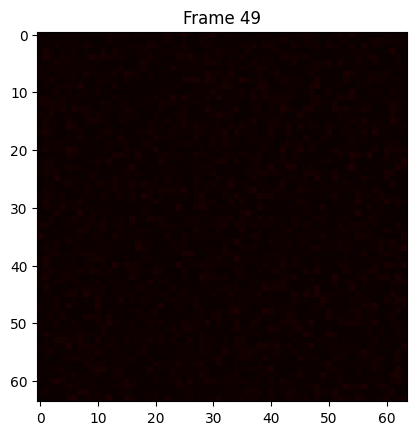

In [6]:
import matplotlib.pyplot as plt
from IPython.display import HTML
frames = get_frames(gt_choices)
anim = animate(frames, 20)
HTML(anim.to_html5_video())

In [7]:
masked_model = multifirefly_model
num_particles = 100
step_init_args = max_fireflies
smc_sampler = make_sequential_monte_carlo_sampler(masked_model, gt_choices, num_particles, num_steps=TIME_STEPS)
key, smc_key = jax.random.split(key)
smc_particles = jax.jit(smc_sampler)(smc_key, step_init_args)

In [8]:
batched_choicemap = jax.vmap(lambda tr: tr.get_sample(), in_axes=(0,))(smc_particles)

(50, 64, 64)
(50, 64, 64)
(50, 64, 64)


KeyboardInterrupt: 

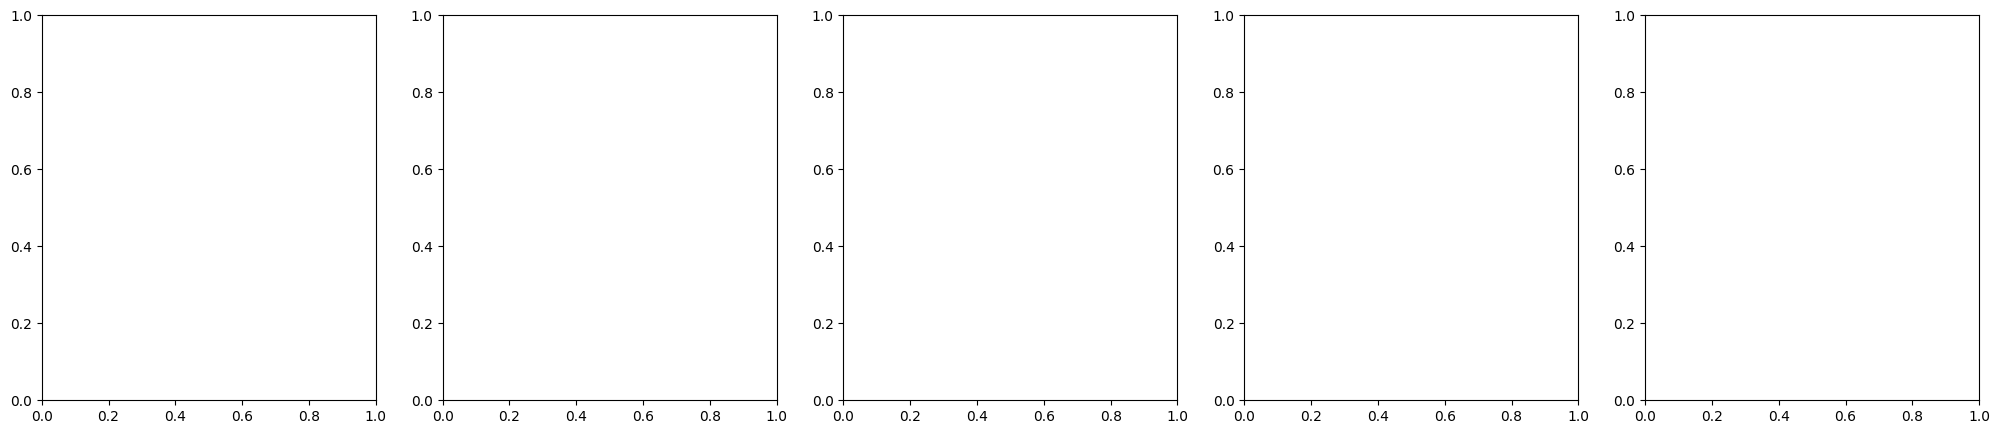

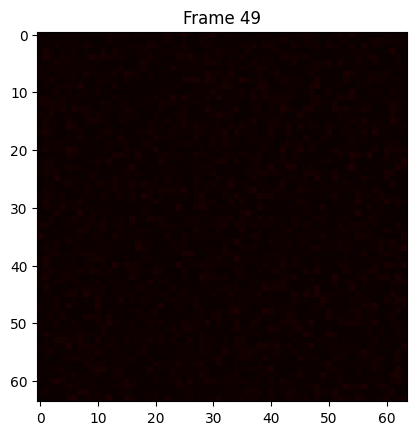

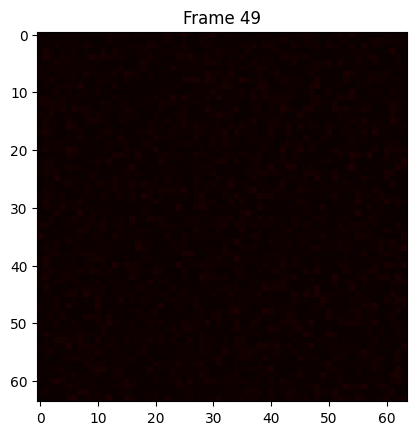

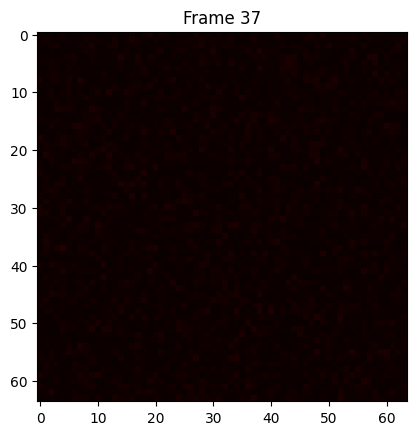

In [21]:
best_weights, best_particles = jax.lax.top_k(smc_particles.score, 5)
fig, axs = plt.subplots(1,5, figsize=(25, 5))
for i in range(5):
    frames = batched_choicemap["steps", i, "observations", "pixels"].value
    anim = animate(frames, 10)
    HTML(anim.to_jshtml())
plt.show()

In [29]:
model_init_args = (max_fireflies, jnp.arange(TIME_STEPS) <= 0)
key, init_keys = and_new_keys(key, num_particles)
init_chm = make_step_choicemap(gt_choices, 0)
init_particles, init_weights = jax.vmap(masked_model.importance, in_axes=(0, None, None))(
            init_keys, init_chm, model_init_args)

In [36]:
key, step_keys = and_new_keys(key, num_particles)

update_problem = make_masked_combinator_step_update_problem(
                step_init_args, gt_choices, 1, TIME_STEPS)
step_particles, step_weights, _, _ = jax.vmap(masked_model.update, in_axes=(0, 0, None))(
                step_keys, init_particles, update_problem)